## This model has the following characteristics:
* No feature engineering
* Applying Conv2D to raw transactions

In [1]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow import set_random_seed
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.preprocessing.text import *

Using TensorFlow backend.


In [6]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
from itertools import combinations

# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#  tf.logging.set_verbosity(tf.logging.ERROR) <- logging이 버전업그레이드에서 사용 X라함

# from tensorflow import set_random_seed 
# 위에 코드 안됨에 대한 답변: In Tensoflow2 there is no need to perform
# from tensorflow import set_random_seed
# in order to run
# set_random_seed(x)
# (as it was in older version)
# Only have to run
# import tensorflow
# tensorflow.random.set_seed(x)

tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping

### Read Data

In [33]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_test.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,3500,2007-01-16 00:00:00,부산본점,735126,기초A,화장품,2465000
1,3500,2007-01-20 00:00:00,부산본점,443227,비지니스군,셔츠,675000
2,3500,2007-03-02 00:00:00,부산본점,461257,트래디셔널Ⅱ,트래디셔널,1840000
3,3500,2007-03-17 00:00:00,부산본점,735126,기초A,화장품,350000
4,3500,2007-03-17 00:00:00,부산본점,245219,트래디셔널,트래디셔널,5014000


### Transform Data

In [34]:
level = 'gds_grp_nm'
items = list(set(df_train[level]) | set(df_test[level]))
ncol = len(items)

def make_image(df):
    x = pd.DataFrame({'cust_id': df.cust_id.unique()})
    y = pd.DataFrame({level: items})
    z = pd.DataFrame({'week_day': np.arange(7)})
    df_pad = (
        x.assign(key=1)
        .merge(y.assign(key=1), on="key")
        .merge(z.assign(key=1), on="key")
        .drop("key", axis=1)
        .assign(amount=0)
    )
    df['week_day'] = pd.to_datetime(df.tran_date).dt.weekday
    df_all = pd.concat([df, df_pad], sort=False, axis=0)
    x = pd.pivot_table(df_all.query('amount >= 0'), 
                       index=['cust_id','week_day'], columns=level, 
                       values='amount', aggfunc=np.size, fill_value=0)
    x = np.array(x).reshape(-1,7*ncol) - 1
    return x.reshape(-1,7,ncol,1)
#    x = np.array(x).reshape(-1,7*ncol) - 1
#    return (x / x.max(1).reshape(-1,1)).reshape(-1,7,ncol,1)

X_train = make_image(df_train)
X_test = make_image(df_test)

X_train.shape, X_test.shape

((3500, 7, 331, 1), (2482, 7, 331, 1))

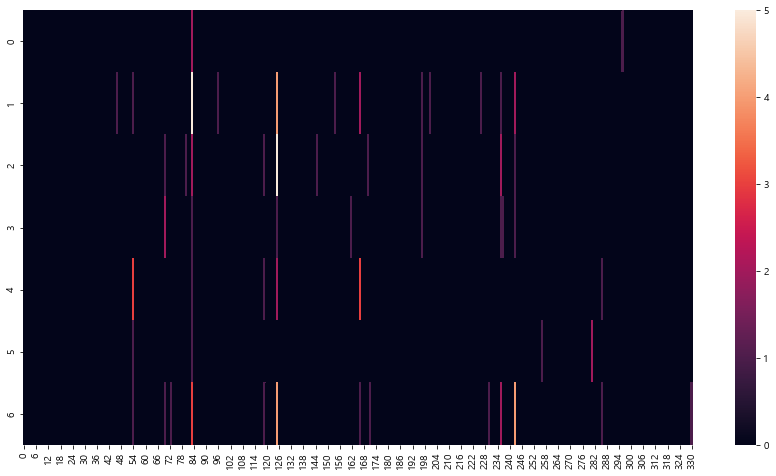

In [35]:
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(X_train.reshape(-1,7,ncol)[300], ax=ax)
plt.show()

### Build Models

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2317)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2317)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2318      
Total params: 2,320
Trainable params: 2,320
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/50
2800/2800 [==============================] - 0s 136us/step - loss: 0.6582 - acc: 0.6082 - val_loss: 0.6457 - val_acc: 0.6229
Epoch 2/50
2800/2800 [==============================] - 0s 104us/st

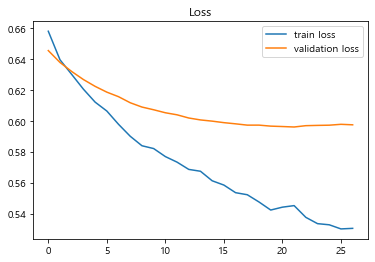

In [36]:
model = Sequential()
model.add(Conv2D(1, kernel_size=(1, 1),strides=(1,1), activation='tanh', input_shape=(7,ncol,1)))
#model.add(layers.MaxPooling2D(pool_size=(2, 1)))
#model.add(layers.Conv2D(1, kernel_size=(1, 1),strides=(1,1), activation='tanh'))
model.add(Flatten())
model.add(Dropout(0.4))
#model.add(layers.Dense(16, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc'])
#model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
history = model.fit(train_x, train_y, 
                    epochs=50, batch_size=128, 
                    validation_data=(valid_x, valid_y), callbacks=[EarlyStopping(patience=5)])

print(roc_auc_score(valid_y, model.predict(valid_x)))

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [38]:

intermediate_layer_model = Model(inputs=model.input,
                                outputs=model.output)
intermediate_output = intermediate_layer_model.predict(X_train)
intermediate_output

array([[0.16730952],
       [0.56152284],
       [0.5458121 ],
       ...,
       [0.48437077],
       [0.40272388],
       [0.24233158]], dtype=float32)

In [39]:
X_train_nm = pd.DataFrame(intermediate_output)

In [40]:

intermediate_layer_model = Model(inputs=model.input,
                                outputs=model.output)
intermediate_output = intermediate_layer_model.predict(X_test)
intermediate_output

array([[0.6138411 ],
       [0.4153191 ],
       [0.02055949],
       ...,
       [0.64749634],
       [0.45367432],
       [0.42576596]], dtype=float32)

In [41]:
X_test_nm = pd.DataFrame(intermediate_output)

# 대분류

### Read Data

In [43]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_test.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,3500,2007-01-16 00:00:00,부산본점,735126,기초A,화장품,2465000
1,3500,2007-01-20 00:00:00,부산본점,443227,비지니스군,셔츠,675000
2,3500,2007-03-02 00:00:00,부산본점,461257,트래디셔널Ⅱ,트래디셔널,1840000
3,3500,2007-03-17 00:00:00,부산본점,735126,기초A,화장품,350000
4,3500,2007-03-17 00:00:00,부산본점,245219,트래디셔널,트래디셔널,5014000


### Transform Data

In [44]:
level = 'gds_grp_mclas_nm'
items = list(set(df_train[level]) | set(df_test[level]))
ncol = len(items)

def make_image(df):
    x = pd.DataFrame({'cust_id': df.cust_id.unique()})
    y = pd.DataFrame({level: items})
    z = pd.DataFrame({'week_day': np.arange(7)})
    df_pad = (
        x.assign(key=1)
        .merge(y.assign(key=1), on="key")
        .merge(z.assign(key=1), on="key")
        .drop("key", axis=1)
        .assign(amount=0)
    )
    df['week_day'] = pd.to_datetime(df.tran_date).dt.weekday
    df_all = pd.concat([df, df_pad], sort=False, axis=0)
    x = pd.pivot_table(df_all.query('amount >= 0'), 
                       index=['cust_id','week_day'], columns=level, 
                       values='amount', aggfunc=np.size, fill_value=0)
    x = np.array(x).reshape(-1,7*ncol) - 1
    return x.reshape(-1,7,ncol,1)
#    x = np.array(x).reshape(-1,7*ncol) - 1
#    return (x / x.max(1).reshape(-1,1)).reshape(-1,7,ncol,1)

X_train = make_image(df_train)
X_test = make_image(df_test)

X_train.shape, X_test.shape

((3500, 7, 49, 1), (2482, 7, 49, 1))

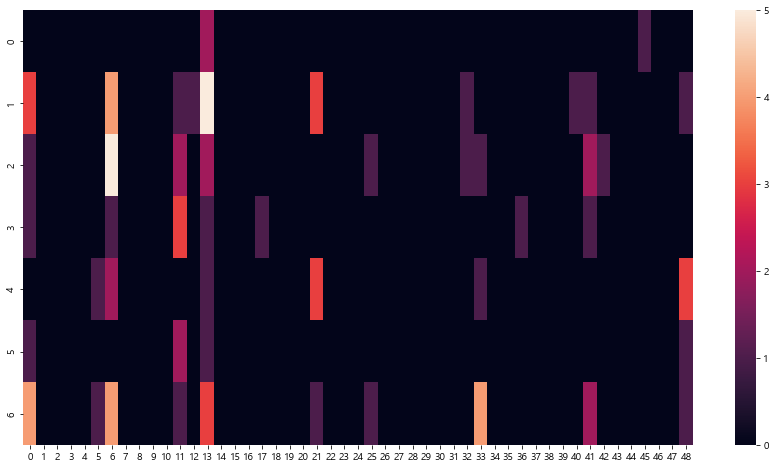

In [45]:
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(X_train.reshape(-1,7,ncol)[300], ax=ax)
plt.show()

### Build Models

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 7, 49, 1)          2         
_________________________________________________________________
flatten_9 (Flatten)          (None, 343)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 343)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 344       
Total params: 346
Trainable params: 346
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/50
2800/2800 [==============================] - 0s 58us/step - loss: 0.6590 - acc: 0.6050 - val_loss: 0.6592 - val_acc: 0.6000
Epoch 2/50
2800/2800 [==============================] - 0s 19us/step - l

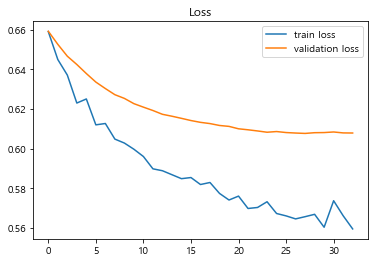

In [46]:
model = Sequential()
model.add(Conv2D(1, kernel_size=(1, 1),strides=(1,1), activation='tanh', input_shape=(7,ncol,1)))
#model.add(layers.MaxPooling2D(pool_size=(2, 1)))
#model.add(layers.Conv2D(1, kernel_size=(1, 1),strides=(1,1), activation='tanh'))
model.add(Flatten())
model.add(Dropout(0.4))
#model.add(layers.Dense(16, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc'])
#model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
history = model.fit(train_x, train_y, 
                    epochs=50, batch_size=128, 
                    validation_data=(valid_x, valid_y), callbacks=[EarlyStopping(patience=5)])

print(roc_auc_score(valid_y, model.predict(valid_x)))

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [47]:

intermediate_layer_model = Model(inputs=model.input,
                                outputs=model.output)
intermediate_output = intermediate_layer_model.predict(X_train)
intermediate_output

array([[0.11899692],
       [0.5760154 ],
       [0.59567684],
       ...,
       [0.47445717],
       [0.4060193 ],
       [0.15802874]], dtype=float32)

In [48]:
X_train_mclas = pd.DataFrame(intermediate_output)

In [49]:

intermediate_layer_model = Model(inputs=model.input,
                                outputs=model.output)
intermediate_output = intermediate_layer_model.predict(X_test)
intermediate_output

array([[0.6277454 ],
       [0.43648183],
       [0.06126493],
       ...,
       [0.72484535],
       [0.3777662 ],
       [0.4393708 ]], dtype=float32)

In [50]:
X_test_mclas = pd.DataFrame(intermediate_output)

# 소분류

### Read Data

In [23]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_test.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,3500,2007-01-16 00:00:00,부산본점,735126,기초A,화장품,2465000
1,3500,2007-01-20 00:00:00,부산본점,443227,비지니스군,셔츠,675000
2,3500,2007-03-02 00:00:00,부산본점,461257,트래디셔널Ⅱ,트래디셔널,1840000
3,3500,2007-03-17 00:00:00,부산본점,735126,기초A,화장품,350000
4,3500,2007-03-17 00:00:00,부산본점,245219,트래디셔널,트래디셔널,5014000


### Transform Data

In [24]:
level = 'goods_id'
items = list(set(df_train[level]) | set(df_test[level]))
ncol = len(items)

def make_image(df):
    x = pd.DataFrame({'cust_id': df.cust_id.unique()})
    y = pd.DataFrame({level: items})
    z = pd.DataFrame({'week_day': np.arange(7)})
    df_pad = (
        x.assign(key=1)
        .merge(y.assign(key=1), on="key")
        .merge(z.assign(key=1), on="key")
        .drop("key", axis=1)
        .assign(amount=0)
    )
    df['week_day'] = pd.to_datetime(df.tran_date).dt.weekday
    df_all = pd.concat([df, df_pad], sort=False, axis=0)
    x = pd.pivot_table(df_all.query('amount >= 0'), 
                       index=['cust_id','week_day'], columns=level, 
                       values='amount', aggfunc=np.size, fill_value=0)
    x = np.array(x).reshape(-1,7*ncol) - 1
    return x.reshape(-1,7,ncol,1)
#    x = np.array(x).reshape(-1,7*ncol) - 1
#    return (x / x.max(1).reshape(-1,1)).reshape(-1,7,ncol,1)

X_train = make_image(df_train)
X_test = make_image(df_test)

X_train.shape, X_test.shape

((3500, 7, 3799, 1), (2482, 7, 3799, 1))

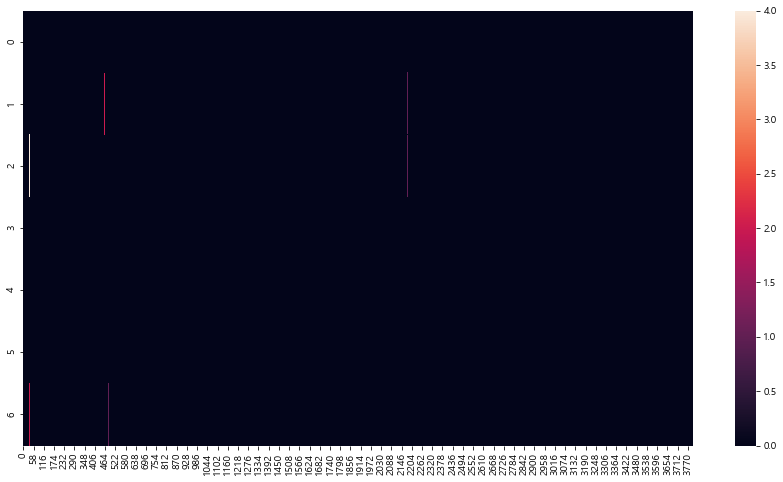

In [25]:
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(X_train.reshape(-1,7,ncol)[300], ax=ax)
plt.show()

### Build Models

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 7, 3799, 1)        2         
_________________________________________________________________
flatten_7 (Flatten)          (None, 26593)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 26593)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 26594     
Total params: 26,596
Trainable params: 26,596
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/50
2800/2800 [==============================] - 4s 1ms/step - loss: 0.6661 - acc: 0.6082 - val_loss: 0.6573 - val_acc: 0.6086
Epoch 2/50
2800/2800 [==============================] - 3s 1ms/step

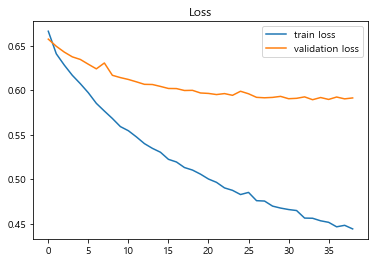

In [26]:
model = Sequential()
model.add(Conv2D(1, kernel_size=(1, 1),strides=(1,1), activation='tanh', input_shape=(7,ncol,1)))
#model.add(layers.MaxPooling2D(pool_size=(2, 1)))
#model.add(layers.Conv2D(1, kernel_size=(1, 1),strides=(1,1), activation='tanh'))
model.add(Flatten())
model.add(Dropout(0.4))
#model.add(layers.Dense(16, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc'])
#model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
history = model.fit(train_x, train_y, 
                    epochs=50, batch_size=128, 
                    validation_data=(valid_x, valid_y), callbacks=[EarlyStopping(patience=5)])

print(roc_auc_score(valid_y, model.predict(valid_x)))

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [27]:

intermediate_layer_model = Model(inputs=model.input,
                                outputs=model.output)
intermediate_output = intermediate_layer_model.predict(X_train)
intermediate_output

array([[0.1021758 ],
       [0.47940373],
       [0.4967052 ],
       ...,
       [0.4708066 ],
       [0.41716054],
       [0.0622539 ]], dtype=float32)

In [28]:
X_train_goods = pd.DataFrame(intermediate_output)

In [29]:

intermediate_layer_model = Model(inputs=model.input,
                                outputs=model.output)
intermediate_output = intermediate_layer_model.predict(X_test)
intermediate_output

array([[0.58394307],
       [0.34966195],
       [0.02990183],
       ...,
       [0.4606137 ],
       [0.40705827],
       [0.388725  ]], dtype=float32)

In [30]:
X_test_goods = pd.DataFrame(intermediate_output)

In [51]:
display(X_train_nm)

display(X_train_mclas)

display(X_train_goods)


,0
0,0.167310
1,0.561523
2,0.545812
3,0.329218
4,0.438546
...,...
3495,0.507663
3496,0.422339
3497,0.484371
3498,0.402724


,0
0,0.118997
1,0.576015
2,0.595677
3,0.333982
4,0.405885
...,...
3495,0.520769
3496,0.384672
3497,0.474457
3498,0.406019


,0
0,0.102176
1,0.479404
2,0.496705
3,0.492453
4,0.433425
...,...
3495,0.509415
3496,0.572425
3497,0.470807
3498,0.417161


In [68]:
X_train_cnn2 = pd.concat([X_train_nm, X_train_mclas, X_train_goods], axis=1)
X_test_cnn2 = pd.concat([X_test_nm, X_test_mclas, X_test_goods], axis=1)

In [71]:
X_train_cnn2.columns=['cnn2_nm', 'cnn2_mclas', 'cnn2_goods']
X_test_cnn2.columns=['cnn2_nm', 'cnn2_mclas', 'cnn2_goods']

In [72]:
X_train_cnn2

,cnn2_nm,cnn2_mclas,cnn2_goods
0,0.167310,0.118997,0.102176
1,0.561523,0.576015,0.479404
2,0.545812,0.595677,0.496705
3,0.329218,0.333982,0.492453
4,0.438546,0.405885,0.433425
...,...,...,...
3495,0.507663,0.520769,0.509415
3496,0.422339,0.384672,0.572425
3497,0.484371,0.474457,0.470807
3498,0.402724,0.406019,0.417161


In [76]:
X_train_cnn2.to_csv('X_train_cnn2.csv', encoding='cp949')
X_test_cnn2.to_csv('X_test_cnn2.csv', encoding='cp949')

In [73]:
X_train = X_train_cnn2
X_test = X_test_cnn2
y_train = pd.read_csv('y_train.csv').gender

DNN learning curve 1/5


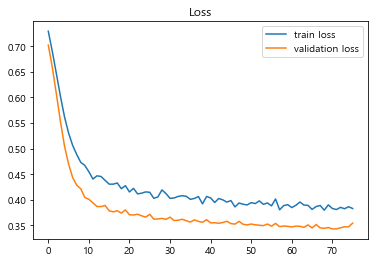

AUC 0.9297347443650358
DNN learning curve 2/5


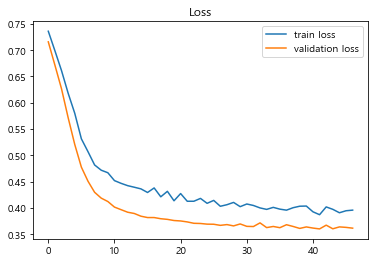

AUC 0.9225966398271115
DNN learning curve 3/5


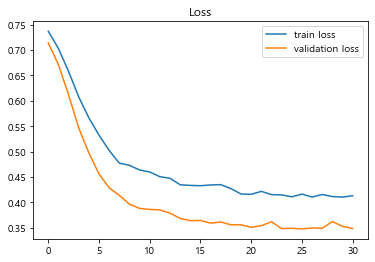

AUC 0.933333918893993
DNN learning curve 4/5


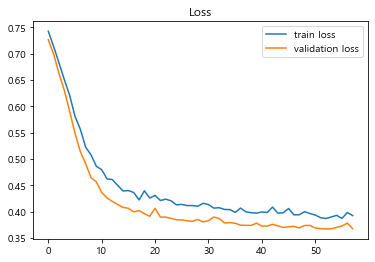

AUC 0.9214861908668308
DNN learning curve 5/5


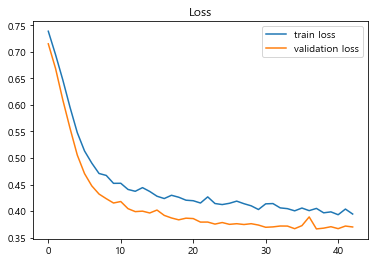

AUC 0.9261955235443858

Validation Summary:
2    0.933334
0    0.929735
4    0.926196
1    0.922597
3    0.921486
dtype: float64
mean=0.92667, std=0.005


In [74]:
# Set hyper-parameters for power mean ensemble 
N = 5
p = 3.5
preds = []
aucs = []

for i in range(N):
    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])  
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)], verbose=0)


    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   

### Make Submissions

In [6]:
pred = model.predict(X_test)[:,0]
fname = 'conv2d_submit.csv'
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'conv2d_submit.csv' is ready to submit.


## End